# Damped and periodically forced Duffing equation 


We consider the damped Duffing equation
$$
\dot{x}	=y, \dot{y}	=x-x^{3}-dy,
$$
with damping coefficient d=0.0141, and perform a change of coordinates 

$$\left(x,y\right)\mapsto\varphi=\left(\varphi_{1},\varphi_{2}\right)$$
that moves the stable focus at $(x,y)=(1,0)$ to the origin and makes the linear part block-diagonal. The resulting system is of the form

$$
\dot{\varphi}=A\varphi+f\left(\varphi\right),\qquad f\left(\varphi\right)=\mathcal{O}\left(\left|\varphi\right|^{2}\right),
$$
where
$$
A=\begin{pmatrix}-\alpha & -\omega\\
\omega & -\alpha
\end{pmatrix},\qquad\omega=1.4142,\quad\alpha=0.00707.
$$

## Analytic linearization

Here we will use the equations directly to construct the Taylor-series approximation of the linearization and its iverse. The computations are done symbolically with SymPy

We first perform the linear change of coordinates

In [140]:
import sympy as sy
import numpy as np
from scipy.integrate import solve_ivp
x, y, delta = sy.symbols('x y \delta', reals=True)
f1 = y
f2 = x - x**3 - delta*y
f = sy.Matrix([f1, f2])
f = f.subs(delta, 0.01*np.sqrt(2))
fps = sy.solve(f, [x, y], dict = True) # compute the fixed points 
Df = f.jacobian([x,y]).subs(fps[0])

vec = np.array(Df.eigenvects()[0][2][0], dtype=complex)
T = sy.Matrix(np.hstack((np.real(vec), np.imag(vec))))

In [141]:
sy.simplify(T.inv()@Df@T)

Matrix([
[-0.00707106781186548,    -1.41419588459308],
[    1.41419588459308, -0.00707106781186548]])

The forcing vector in physical coordinates is 
$$
\begin{pmatrix} 
0 \\ 1
\end{pmatrix}
$$
Transformed to the diagonalized coordinates:

In [142]:
T.inv()@sy.Matrix([0,1])

Matrix([
[-0.00612380090494769],
[    1.22474487139159]])

Define the new coordinates $\varphi$ as
$$
\begin{pmatrix}x \\ y\end{pmatrix} = T\varphi - \begin{pmatrix} -1 \\0 \end{pmatrix}
$$

In [143]:
z1, z2 = sy.symbols('z_1 z_2')
newcoords = sy.Matrix([z1, z2])
oldcoords = T@newcoords - sy.Matrix([-1, 0])

In [144]:
new_f = T.inv()@f.subs([(x, oldcoords[0]), (y, oldcoords[1])])

### Determine $\kappa^{-1}$

In [145]:

# Define the symbols
x, y, i, j = sy.symbols('x y i j')
maxorder = 7

# Define Indexed Bases
a = sy.IndexedBase('a')
b = sy.IndexedBase('b')

# Translate the summations
Y1 = sy.summation(a[i, j] * x**(i - 1) * y**(j - 1), (i, 1, maxorder + 1), (j, 1, maxorder + 1))
Y2 = sy.summation(b[i, j] * x**(i - 1) * y**(j - 1), (i, 1, maxorder + 1), (j, 1, maxorder + 1))

For the linearizing transformation, we assume that 

$$
\gamma_1 = \kappa^{-1}(\varphi)_1 = \sum_{i,j} a_{ij}\varphi_1^i \varphi_2^j
$$

and

$$
\gamma_2 = \kappa^{-1}(\varphi)_2 =\sum_{i,j} b_{ij}\varphi_1^i \varphi_2^j
$$


We then obtain the invariance equation by time-differentiation.

We have
$$
\frac{d}{dt}\gamma_1 = \frac{\partial \kappa^{-1}_1}{\partial \varphi_1} \dot{\varphi}_1 + \frac{\partial \kappa^{-1}_1}{\partial \varphi_2} \dot{\varphi}_2
$$
and at the same time
$$
\frac{d}{dt}\gamma_1 = -\alpha \gamma_1 - \omega \gamma_2.
$$

Therefore, the transformation must satisfy 

$$
-\alpha \kappa^{-1}(\varphi)_1 - \omega \kappa^{-1}(\varphi)_2 = \frac{\partial \kappa^{-1}_1}{\partial \varphi_1} \dot{\varphi}_1 + \frac{\partial \kappa^{-1}_1}{\partial \varphi_2} \dot{\varphi}_2
$$

We obtain the second component similarly.

$$
-\alpha \kappa^{-1}(\varphi)_1 + \omega \kappa^{-1}(\varphi)_2 = \frac{\partial \kappa^{-1}_2}{\partial \varphi_1} \dot{\varphi}_1 + \frac{\partial \kappa^{-1}_2}{\partial \varphi_2} \dot{\varphi}_2
$$

We will solve these equations order-by-order, for every order of $\varphi$.

In [146]:
# Substitutions for Y1
Y1_substituted = Y1.subs({a[1,1]: 0, 
                          a[2,1]: 1, 
                          a[1,2]: 0})

# Substitutions for Y2
Y2_substituted = Y2.subs({b[1,1]: 0, 
                          b[2,1]: 0, 
                          b[1,2]: 1})

In [147]:
from sympy import degree_list

def extract_up_to_n(expression, variables, Nmax):
    # Break the expression into a list of monomials
    monomials = expression.as_coefficients_dict()
    
    # Filter and sum the terms
    return sum(coeff * monomial for monomial, coeff in monomials.items() 
               if sum(sy.degree_list(monomial, *variables)[:len(variables)]) <= Nmax)


In [148]:
A = new_f.jacobian([z1,z2]).subs({z1: 0,
                            z2: 0})

In [149]:
Y1 =  extract_up_to_n(sy.expand(Y1_substituted), [x,y], maxorder)
Y2 =  extract_up_to_n(sy.expand(Y2_substituted), [x,y], maxorder)

In [150]:
udot = A[0,0] * Y1 + A[0,1] * Y2 # the linearized dynamics is enforced
vdot =  A[1,0] * Y1 + A[1,1] * Y2

In [151]:
ff = new_f.subs([(z1, x), (z2, y)])

In [152]:
L1 = Y1.diff(x)*ff[0] + Y1.diff(y)*ff[1]
L2 = Y2.diff(x)*ff[0] + Y2.diff(y)*ff[1]

R = [udot, vdot]

Create the invariance equations

In [153]:
eq1 = extract_up_to_n(sy.expand(R[0] - L1), [x,y], maxorder)
eq2 = extract_up_to_n(sy.expand(R[1] - L2), [x,y], maxorder)

In [154]:
def coefficient_list(expression, variables):
    poly = sy.Poly(expression, *variables)
    degrees = [poly.degree(var) for var in variables]
    coeffs = {}
    for i in range(degrees[0] + 1):
        for j in range(degrees[1] + 1):
            coeffs[(i, j)] = poly.coeff_monomial(variables[0]**i * variables[1]**j)
    return coeffs

In [155]:
coeff1 = coefficient_list(eq1, [x,y])
coeff2 = coefficient_list(eq2, [x,y])

In [156]:
# Function to extract variables from a dictionary of coefficients
def extract_variables(coeff_dict):
    return set().union(*[coeff.free_symbols for coeff in coeff_dict.values()])

# Extract variables from coeff1 and coeff2
variables1 = extract_variables(coeff1)
variables2 = extract_variables(coeff2)

# Extract variables from RHS
rhs_variables = set(ff.free_symbols)


# Calculate Coefficients1 and Coefficients2
Coefficients1 = variables1 - set(set((x, y)).union(rhs_variables)).union({a,b})
Coefficients2 = variables2 - ({x, y}.union(rhs_variables)).union({a,b})

# Combine the unique variables
cc = Coefficients1.union(Coefficients2)

In [157]:

Equations = []

for item in list(coeff1.items()):
    Equations.append(item[1])
for item in list(coeff2.items()):
    Equations.append(item[1])

# Equations is now a list of equations

In [158]:
symbols = []
for i in range(1,maxorder+1):
    for j in range(1,maxorder+1):

        if i + j < maxorder+1:
            symbols.append(a[i,j])
            symbols.append(b[i,j])

In [159]:
sol = sy.solve(Equations)
Y1_subbed = Y1.subs(sol)
Y2_subbed = Y2.subs(sol)


In [160]:
transformations = {}
transformations['gamma_1_phi1_phi2'] = Y1_subbed
transformations['gamma_2_phi1_phi2'] = Y2_subbed


We save now the analytically computed linearizing transformation with order 9 to save time for later computations. 

In [161]:
from joblib import dump

In [35]:
dump(transformations, 'saved_models/duffing_kappainv_order9.symbolic')

['saved_models/duffing_kappainv_order9.symbolic']

In [36]:
#transformations = load('saved_models_duffing_kappainv_order9.symbolic')

In [162]:
Y1_np = sy.lambdify([x,y], transformations['gamma_1_phi1_phi2'])
Y2_np = sy.lambdify([x,y], transformations['gamma_2_phi1_phi2'])
transformations['gamma_1_phi1_phi2_numpy'] = Y1_np
transformations['gamma_2_phi1_phi2_numpy'] = Y2_np

### Determine $\kappa$

Now we seek 

$$
\varphi_1 = \kappa(\gamma)_1 = \sum_{i,j} \hat{a}_{ij}\gamma_1^i \gamma_2^j
$$

and

$$
\varphi_2 = \kappa(\gamma)_2 =\sum_{i,j} \hat{b}_{ij}\gamma_1^i \gamma_2^j
$$



The invariance equations can be obtained similarly as before

This transformation must satisfy 

$$
\dot{\varphi}_1 = \frac{\partial \kappa_1}{\partial \gamma_1} \left(-\alpha \gamma_1 - \omega \gamma_2 \right) + \frac{\partial \kappa_1}{\partial \gamma_2} \left(-\alpha \gamma_1 + \omega \gamma_2 \right)
$$
and
$$
\dot{\varphi}_2 = \frac{\partial \kappa_2}{\partial \gamma_1} \left(-\alpha \gamma_1 - \omega \gamma_2 \right) + \frac{\partial \kappa_2}{\partial \gamma_2} \left(-\alpha \gamma_1 + \omega \gamma_2 \right),
$$

where now $\dot{\varphi}$ is the right-hand side of the original, nonlinear ODE.



In [164]:


u, v, i, j = sy.symbols('u v i j')
maxorder = 7
# redefine the coefficients
a = sy.IndexedBase('a')
b = sy.IndexedBase('b')

Y1 = sy.summation(a[i, j] * u**(i - 1) * v**(j - 1), (i, 1, maxorder + 1), (j, 1, maxorder + 1))
Y2 = sy.summation(b[i, j] * u**(i - 1) * v**(j - 1), (i, 1, maxorder + 1), (j, 1, maxorder + 1))

In [165]:
# Substitutions for Y1
Y1_substituted = Y1.subs({a[1,1]: 0, 
                          a[2,1]: 1, 
                          a[1,2]: 0})

# Substitutions for Y2
Y2_substituted = Y2.subs({b[1,1]: 0, 
                          b[2,1]: 0, 
                          b[1,2]: 1})

In [166]:
Y1 =  extract_up_to_n(sy.expand(Y1_substituted), [u,v], maxorder)
Y2 =  extract_up_to_n(sy.expand(Y2_substituted), [u,v], maxorder)

In [167]:
udot = A[0,0] * u + A[0,1]*v
vdot = A[1,0] * u + A[1,1] * v

In [168]:
L1 = Y1.diff(u)*udot + Y1.diff(v)*vdot
L2 = Y2.diff(u)*udot + Y2.diff(v)*vdot
R = sy.expand(ff.subs({x: Y1, 
    y : Y2}))

In [169]:
eq1 = extract_up_to_n(sy.expand(R[0] - L1), [u,v], maxorder)
eq2 = extract_up_to_n(sy.expand(R[1] - L2), [u,v], maxorder)

In [170]:
coeff1 = coefficient_list(eq1, [u,v])
coeff2 = coefficient_list(eq2, [u,v])

In [171]:

# Extract variables from coeff1 and coeff2
variables1 = extract_variables(coeff1)
variables2 = extract_variables(coeff2)

# Extract variables from RHS
rhs_variables = set(ff.free_symbols)


# Calculate Coefficients1 and Coefficients2
Coefficients1 = variables1 - set(set((u, v)).union(rhs_variables)).union({a,b})
Coefficients2 = variables2 - ({u, v}.union(rhs_variables)).union({a,b})

# Combine the unique variables
cc = Coefficients1.union(Coefficients2)

In [172]:
Equations = []

for item in list(coeff1.items()):
    Equations.append(item[1])
for item in list(coeff2.items()):
    Equations.append(item[1])

In [173]:
symbols = []
for i in range(1,maxorder+1):
    for j in range(1,maxorder+1):

        if i + j < maxorder+1:
            symbols.append(a[i,j])
            symbols.append(b[i,j])

In [174]:
sol = sy.solve(Equations)

In [175]:
Y1_subbed = Y1.subs(sol[0])
Y2_subbed = Y2.subs(sol[0])


In [176]:
Y1_np = sy.lambdify([u,v], Y1_subbed)
Y2_np = sy.lambdify([u,v], Y2_subbed)


In [177]:
transformations_kappa = {}
transformations_kappa['phi1_1_gamma1_gamma2'] = Y1_subbed
transformations_kappa['phi2_2_gamma1_gamma2'] = Y2_subbed



In [54]:
dump(transformations_kappa, 'saved_models/duffing_kappa_order9.symbolic')

['saved_models/duffing_kappa_order9.symbolic']

In [31]:
#transformations_kappa = load('saved_models_duffing_kappa_order9.symbolic')

In [178]:
Y1_np = sy.lambdify([u,v], transformations_kappa['phi1_1_gamma1_gamma2'])
Y2_np = sy.lambdify([u,v], transformations_kappa['phi2_2_gamma1_gamma2'])

# add them to the transformations dictionary
transformations['phi_1_gamma1_gamma2_numpy'] = Y1_np
transformations['phi_2_gamma1_gamma2_numpy'] = Y2_np

### Estimating the radius of convergence 

For simplicity, instead of computing the radius of converggence from the coefficients of the Taylor-series, we estimate it using the point, at which a high-order approximation for the linearizing transformation breaks down. Since for the transformation $\kappa(\varphi)$, it has to hold that

$$
\kappa^{-1}\left(\kappa(\varphi)\right) = \varphi,
$$

we get a good approximation for the range of validity of the linearization by evaluating $\kappa^{-1}\left(\kappa(\varphi)\right)$. 

For example, along the diagonal $\varphi_1 = \varphi_2$ we obtain the following

In [179]:
import matplotlib.pyplot as plt

(-0.2, 0.2)

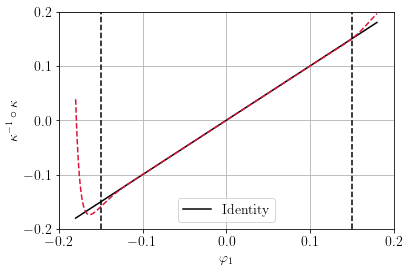

In [181]:
xx = np.linspace(-0.18, 0.18, 1000)

yy = np.squeeze(transformations['phi_1_gamma1_gamma2_numpy'](transformations['gamma_1_phi1_phi2_numpy'](xx, xx),
                                                            transformations['gamma_2_phi1_phi2_numpy'](xx, xx)))
plt.plot(xx, xx, '-', c= 'black', label = 'Identity')
plt.plot(xx, yy, '--', c='crimson')
plt.legend()
plt.grid()
plt.plot([-0.15, -0.15],[-0.2, 0.2], '--', c='black')
plt.plot([0.15, 0.15],[-0.2, 0.2], '--', c='black')

plt.xlabel(u'$\\varphi_1$')
plt.ylabel(u'$\\kappa^{-1} \\circ \\kappa$')
plt.xlim(-0.2, 0.2)
plt.ylim(-0.2, 0.2)


Therefore, we expect the dynamics to be analytically linearizable for 

$$
|\varphi|< R_{crit} \approx 0.15
$$

A more detailed analysis over a grid yields: 

In [182]:
xx = np.linspace(-0.3, 0.3, 200)

XX, YY = np.meshgrid(xx, xx)
phi1__XX = np.squeeze(transformations['phi_1_gamma1_gamma2_numpy'](transformations['gamma_1_phi1_phi2_numpy'](XX, YY),
                                                            transformations['gamma_2_phi1_phi2_numpy'](XX, YY)))

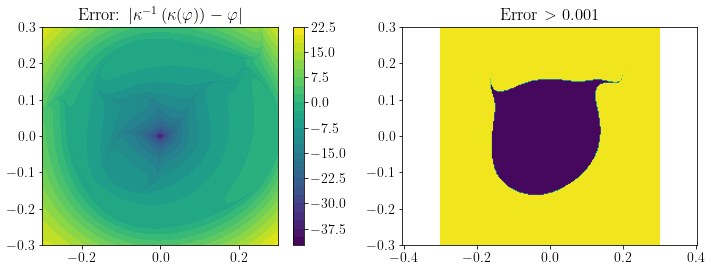

In [183]:
fig = plt.figure(figsize = (10, 4))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cc = ax.contourf(XX, YY, np.log(np.abs(XX - phi1__XX)), 30)
ax.set_title(r'Error: $|\kappa^{-1}\left(\kappa(\varphi)\right) - \varphi|$')
plt.colorbar(cc)
cc = ax2.contourf(XX, YY, np.abs(XX - phi1__XX) > 0.001, 30)

ax2.set_title('Error $>$ 0.001')
ax2.set_xlim(-0.3, 0.3)
ax2.set_ylim(-0.3, 0.3)

plt.axis('equal')

plt.tight_layout()

### Comparison with DDL and DMD, EDMD

In [222]:
import numpy as np


In [223]:
# import distinctipy # can be commented out if distinctipy is not installed
# colors2 = distinctipy.get_colors(10, n_attempts = 7000, rng = 1, colorblind_type='Tritanopia')
# distinctipy.color_swatch(colors2)

In [224]:
colors2 = [(0.03678484251536762, 0.6179966849702221, 0.9739358488787938),
 (0.9973991938671649, 0.271843841793703, 0.3312661650034482),
 (0.46923921134665403, 0.05321353602065504, 0.7589105321169408),
 (0.6518372201847867, 0.02303925652524519, 0.11509491725842236),
(0.2801795133081738, 0.5636756117295652, 0.2994640928542739)]

In [225]:
ff_numpy = sy.lambdify([x, y], ff)

In [226]:
class Duffing_nonlinear:
    def __init__(self, eps, Omega):
        self.eps = eps
        self.Omega = Omega
        self.dimension = 2

    def dynamics(self, x0, t):

        """ODE system
        This function will be passed to the numerical integrator
        Inputs:
            x0: initial values
            t: time
        Outputs:
            x_dot: velocity vector
        """
        x1,x2 = x0
        vel_array = np.squeeze(ff_numpy(x1, x2)) + self.eps/np.sqrt(2) * np.array([1., 1.]) * np.cos(self.Omega*t)
        return np.array(vel_array)
    

In [227]:
A = np.array(A, dtype = float)

In [228]:
def lin_ode(t,x):
    return A@x

In [229]:
def toint(t,x, model):
    return model.dynamics(x,t)

In [230]:
tmax = 800

teval = np.linspace(0, tmax, 16000)

In [231]:
## compute the initial guess for A
v, w = np.linalg.eig(A)
dt = teval[1] - teval[0]
Diag_cont_init = np.diag(np.exp(v * dt))
init_matrix = np.real(w@Diag_cont_init@np.linalg.inv(w))

## Analysis of low amplitude data

In [232]:
low_amplitude_set = {}

In [233]:
ics_for_ddl = [[-0.12, 0.0013333], [0.125, 0.002], [-0.1115, 0.]]
ics_for_ddl_valid = [[-0.11, -0.02]]
ics_for_ddl_test = [[0.103, -0.02]]
omm = 1.6
model = Duffing_nonlinear( 0., omm)
period = 2 *np.pi / omm
converged = np.linspace(0, period, 100)
low_amplitude_set['train_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl]
low_amplitude_set['validation_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl_valid]
low_amplitude_set['test_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl_test]

### Analytic prediction

In [234]:
from sklearn.preprocessing import PolynomialFeatures

In [235]:
def predict_linearization(x0, times):
    u0v0 = np.array([transformations['gamma_1_phi1_phi2_numpy'](*x0),
                     transformations['gamma_2_phi1_phi2_numpy'](*x0)])
    tmax = times[-1]
    sol = solve_ivp(lin_ode, 
                                [0, tmax],
                                u0v0, t_eval = times)
    return np.array([transformations['phi_1_gamma1_gamma2_numpy'](sol.y[0,:], sol.y[1,:]),
             transformations['phi_2_gamma1_gamma2_numpy'](sol.y[0,:], sol.y[1,:])])

In [236]:
linearized = predict_linearization(ics_for_ddl_valid[0], teval)

### EDMD, DMD

In [237]:
from data_driven_linearization.dmd import dmd
from data_driven_linearization.edmd import edmd



In [238]:

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 14,"font.family": "serif",})
plt.rcParams.update({'text.latex.preamble':r"\usepackage{amsmath}"})


In [239]:
deg = 5

In [240]:
Dmd = dmd(low_amplitude_set['train_data'])
Edmd = edmd(low_amplitude_set['train_data'], degree = deg)

In [241]:

nonlin_features = PolynomialFeatures(degree = 5, 
                                     include_bias = False).fit_transform(low_amplitude_set['validation_data'][0].T)


In [242]:
def iterate(x0, A, n):
    iterates = [x0]
    for i in range(n):
        iterates.append(A@iterates[-1])
    return iterates

In [243]:
dmd_pred = np.array(iterate(ics_for_ddl_valid[0],
                            Dmd.coef_, 
                            teval.shape[0] -1))

In [244]:
edmd_pred = np.array(iterate(nonlin_features[0,:],
                            Edmd.coef_, 
                            teval.shape[0] -1))

In [245]:
figure_1 = {}

In [246]:
figure_1['teval'] = teval
figure_1['low_amplitude_set'] = low_amplitude_set['validation_data'][0]
figure_1['low_amplitude_linearized'] = linearized


In [247]:
figure_1['low_amplitude_dmd_pred'] = dmd_pred.T
figure_1['low_amplitude_edmd_pred'] = edmd_pred.T

### DDL

Start DDL from the DMD initial guess

In [248]:
from data_driven_linearization.linearization import DataDrivenLinearization
from data_driven_linearization.differentiation_utils import differentiate_model_symbolic

In [249]:
model = {}
d = DataDrivenLinearization(2, degree = 5)
loss = d.fit(low_amplitude_set['train_data'], initial_matrix = Dmd.coef_, 
           alpha = 0., method = 'with_inverse',  method_optimization = 'trf', verbose = True)
model['ddl'] = d
inverse_transform, inverse_derivative, variables = differentiate_model_symbolic(d.poly, 
                                                                                d.inverse_transformation_model.coef_)

transform, derivative, variables = differentiate_model_symbolic(d.poly, 
                                                                                        d.transformation_coefficients)


inverse_transform_numpy = sy.lambdify([variables], inverse_transform, 'numpy')
derivative_transform_numpy = sy.lambdify([variables], derivative, 'numpy')
transform_numpy = sy.lambdify([variables], transform, 'numpy')
inverse_derivative_transform_numpy = sy.lambdify([variables], inverse_derivative, 'numpy')
v, w = np.linalg.eig(d.linear_model)
dt = teval[1] - teval[0]
Diag_cont = np.diag(np.log(v) / dt)
Cont_non_diag = np.real(w@Diag_cont@np.linalg.inv(w))


Initial cost:  0.5067720664613555
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-3.722e-06 -3.275e-06 ... -7.083e-11 -9.133e-11]
           x: [ 9.972e-01 -7.055e-02 ...  1.313e+01 -2.194e+01]
        cost: 2.937036269784562e-07
         jac: [[-1.218e-01  1.254e-02 ...  0.000e+00 -0.000e+00]
               [-1.224e-01  3.921e-03 ...  0.000e+00 -0.000e+00]
               ...
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -0.000e+00]
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -0.000e+00]]
        grad: [ 3.909e-09 -5.800e-09 ... -6.902e-14 -1.186e-13]
  optimality: 5.799968078288578e-09
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 38
        njev: 32
Final cost:  5.874072539569132e-07


In [250]:
valid_traj = low_amplitude_set['validation_data'][0]

transformed_valid = d.transform(valid_traj)
predicted_ddl = d.predict(valid_traj[:,0], valid_traj.shape[1]-1)
predicted_ddl = np.array(predicted_ddl)
predicted_ddl_trf = d.inverse_transform(np.array(predicted_ddl))

In [251]:
figure_1['low_amplitude_ddl_pred'] = predicted_ddl_trf
figure_1['low_amplitude_ddl_model'] = d

## Analysis of larger amplitude data

In [252]:
large_amplitude_set = {}

In [253]:
ics_for_ddl = [[-0.25, 0.0013333], [0.245, 0.002], [-0.25, 0.]]
ics_for_ddl_valid = [[-0.22, -0.02]]
ics_for_ddl_test = [[0.213, -0.02]]

model = Duffing_nonlinear( 0., omm)
period = 2 *np.pi / omm
converged = np.linspace(0, period, 100)
large_amplitude_set['train_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl]
large_amplitude_set['validation_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl_valid]
large_amplitude_set['test_data'] = [solve_ivp(toint, 
                                [0, tmax],
                                ic, t_eval = teval,
                                args = (model,)).y for ic in ics_for_ddl_test]

In [254]:
linearized = predict_linearization(ics_for_ddl_valid[0], teval)

In [255]:
figure_1['large_amplitude_set'] = large_amplitude_set['validation_data'][0]
figure_1['large_amplitude_linearized'] = linearized

In [256]:
Dmd = dmd(large_amplitude_set['train_data'])
Edmd = edmd(large_amplitude_set['train_data'], degree = deg)

In [257]:

nonlin_features = PolynomialFeatures(degree = 5, 
                                     include_bias = False).fit_transform(large_amplitude_set['validation_data'][0].T)


In [258]:
dmd_pred = np.array(iterate(ics_for_ddl_valid[0],
                            Dmd.coef_, 
                            teval.shape[0] -1))

In [259]:
edmd_pred = np.array(iterate(nonlin_features[0,:],
                            Edmd.coef_, 
                            teval.shape[0] -1))

In [260]:
figure_1['large_amplitude_dmd_pred'] = dmd_pred.T
figure_1['large_amplitude_edmd_pred'] = edmd_pred.T

### DDL

In [261]:
model = {}
d = DataDrivenLinearization(2, degree = 5)
loss = d.fit(large_amplitude_set['train_data'], initial_matrix = Dmd.coef_, 
           alpha = 0., method = 'with_inverse',  method_optimization = 'trf', verbose = True)
model['ddl'] = d
inverse_transform, inverse_derivative, variables = differentiate_model_symbolic(d.poly, 
                                                                                d.inverse_transformation_model.coef_)

transform, derivative, variables = differentiate_model_symbolic(d.poly,
                                                                d.transformation_coefficients)


inverse_transform_numpy = sy.lambdify([variables], inverse_transform, 'numpy')
derivative_transform_numpy = sy.lambdify([variables], derivative, 'numpy')
transform_numpy = sy.lambdify([variables], transform, 'numpy')
inverse_derivative_transform_numpy = sy.lambdify([variables], inverse_derivative, 'numpy')
v, w = np.linalg.eig(d.linear_model)
dt = teval[1] - teval[0]
Diag_cont = np.diag(np.log(v) / dt)
Cont_non_diag = np.real(w@Diag_cont@np.linalg.inv(w))


Initial cost:  92.74745981624993
     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-2.616e-05 -1.803e-05 ...  5.191e-10  6.842e-10]
           x: [ 9.972e-01 -7.008e-02 ...  2.350e-01 -1.642e+00]
        cost: 1.768737353251448e-05
         jac: [[-2.616e-01  2.777e-02 ...  0.000e+00 -0.000e+00]
               [-2.628e-01  9.498e-03 ...  0.000e+00 -0.000e+00]
               ...
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -0.000e+00]
               [ 0.000e+00 -0.000e+00 ...  0.000e+00 -0.000e+00]]
        grad: [ 2.712e-09  5.698e-10 ... -5.693e-13 -9.597e-13]
  optimality: 2.713356857356691e-09
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 51
        njev: 45
Final cost:  3.537474706502903e-05


In [262]:
figure_1['teval'] = teval


In [263]:
valid_traj = large_amplitude_set['validation_data'][0]

transformed_valid = d.transform(valid_traj)
predicted_ddl = d.predict(valid_traj[:,0], valid_traj.shape[1]-1)
predicted_ddl = np.array(predicted_ddl)
predicted_ddl_trf = d.inverse_transform(np.array(predicted_ddl))

In [264]:
figure_1['large_amplitude_ddl_pred'] = predicted_ddl_trf
figure_1['large_amplitude_ddl_model'] = d

## Comparison figure

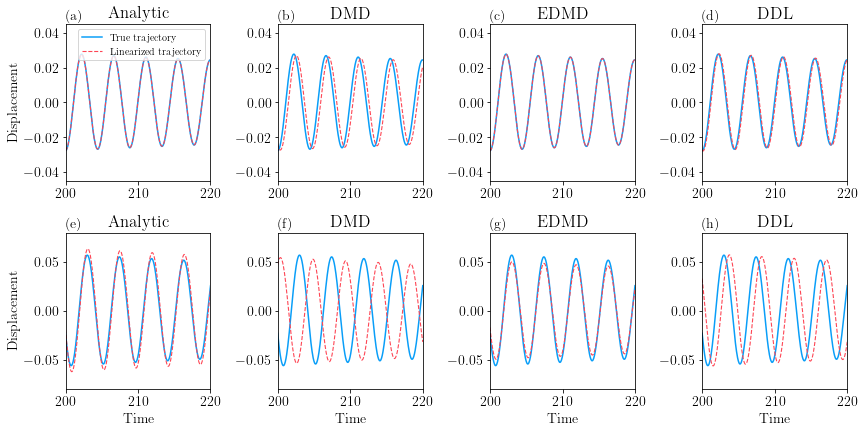

In [280]:
fig, axes = plt.subplots(ncols = 4, nrows = 2, figsize = (12,6))
axes[0,0].plot(figure_1['teval'], figure_1['low_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0], label = 'True trajectory')

axes[0,0].plot(figure_1['teval'], figure_1['low_amplitude_linearized'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1], label = 'Linearized trajectory')
#axes[0,0].set_xlabel('Time')
#axes[0,0].set_ylabel('Displacement')
axes[0,0].set_title('Analytic')


axes[0,1].plot(figure_1['teval'], figure_1['low_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[0,1].plot(figure_1['teval'], figure_1['low_amplitude_dmd_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[0,1].set_title('DMD')


axes[0,2].plot(figure_1['teval'], figure_1['low_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[0,2].plot(figure_1['teval'], figure_1['low_amplitude_edmd_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[0,2].set_title('EDMD')


axes[0,3].plot(figure_1['teval'], figure_1['low_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[0,3].plot(figure_1['teval'], figure_1['low_amplitude_ddl_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[0,3].set_title('DDL')


axes[1,0].plot(figure_1['teval'], figure_1['large_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0], label = 'True trajectory')

axes[1,0].plot(figure_1['teval'], figure_1['large_amplitude_linearized'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1], label = 'Linearized trajectory')
#axes[0,0].set_xlabel('Time')
#axes[0,0].set_ylabel('Displacement')
axes[1,0].set_title('Analytic')


axes[1,1].plot(figure_1['teval'], figure_1['large_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[1,1].plot(figure_1['teval'], figure_1['large_amplitude_dmd_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[1,1].set_title('DMD')


axes[1,2].plot(figure_1['teval'], figure_1['large_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[1,2].plot(figure_1['teval'], figure_1['large_amplitude_edmd_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[1,2].set_title('EDMD')


axes[1,3].plot(figure_1['teval'], figure_1['large_amplitude_set'][0,:],  '-',
               linewidth = 1.5,  c=colors2[0])

axes[1,3].plot(figure_1['teval'], figure_1['large_amplitude_ddl_pred'][0,:], '--', 
               linewidth = 1.1, alpha = 1, c=colors2[1])
axes[1,3].set_title('DDL')


for i in range(4):
    axes[0,i].set_xlim(200, 220)
    axes[0,i].set_ylim(-0.045, 0.045)
    axes[1,i].set_xlim(200, 220)
    axes[1,i].set_ylim(-0.08, 0.08)

axes[0,0].legend(loc = 'upper right', fontsize = 10)
fig.tight_layout()
axes[0,0].set_ylabel('Displacement')
axes[1,0].set_ylabel('Displacement')


for i in range(4):
    axes[1,i].set_xlabel('Time')
    
    
    
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']
for a,l in zip(axes.ravel(), labels):
    a.text(0, 1.03, l,transform=a.transAxes)
#plt.savefig('figure5.pdf', bbox_inches='tight')

In [309]:
dump(figure_1, 'saved_models/figure_5.data')

['saved_models/figure_5.data']

## Forced response curves

In [281]:

large_amplitude_ddl = d

In [282]:
inverse_transform, inverse_derivative, variables = differentiate_model_symbolic(d.poly,
                                                                                d.inverse_transformation_model.coef_)

transform, derivative, variables = differentiate_model_symbolic(d.poly,
                                                                d.transformation_coefficients)

Generate the transformations as strings to better interface with COCO  https://sourceforge.net/p/cocotools/wiki/Home/

In [283]:
str(inverse_transform[0]).replace('**', '.^').replace('x_0', 'u').replace('x_1','v')

'-1.592906369052*u.^5 - 1.8515064772555*u.^4*v + 0.428650964933765*u.^4 - 2.74966696890522*u.^3*v.^2 + 0.689054570038771*u.^3*v + 0.493513135716733*u.^3 - 2.95257874448554*u.^2*v.^3 + 0.931999661832654*u.^2*v.^2 - 1.4373743712398*u.^2*v + 0.283045637429705*u.^2 - 1.38308249378592*u*v.^4 + 0.722201881833066*u*v.^3 + 0.38975444041557*u*v.^2 + 0.0063369135879096*u*v + 1.0*u - 1.16224553452808*v.^5 + 0.515363536088653*v.^4 - 1.45393935844037*v.^3 + 0.579686918910643*v.^2'

In [284]:
str(inverse_transform[1]).replace('**', '.^').replace('x_0', 'u').replace('x_1','v')

'1.59727808679318*u.^5 - 2.00050776005625*u.^4*v - 0.838987055231041*u.^4 + 1.70516661697777*u.^3*v.^2 - 0.245374062643042*u.^3*v + 1.42669804491312*u.^3 - 3.45128742785702*u.^2*v.^3 - 0.0227269547938732*u.^2*v.^2 + 0.408451615796731*u.^2*v + 0.00617077595978708*u.^2 + 0.234955787178839*u*v.^4 - 0.185369059220207*u*v.^3 + 1.45201526167485*u*v.^2 - 0.585564457512424*u*v - 1.64230858446897*v.^5 + 0.823051206440916*v.^4 + 0.13325672627409*v.^3 + 0.00305916327741244*v.^2 + 1.0*v'

In [285]:
str(transform[0]).replace('**', '.^').replace('x_0', 'x').replace('x_1','y')

'-0.165252824846143*x.^5 - 0.515424203848289*x.^4*y + 0.19895199602877*x.^4 - 0.644742797053383*x.^3*y.^2 + 0.22190111412321*x.^3*y - 0.325788741384679*x.^3 - 1.19357961566932*x.^2*y.^3 - 0.0319725579590698*x.^2*y.^2 + 1.4375723607494*x.^2*y - 0.283805568822804*x.^2 - 0.287963203090662*x*y.^4 + 1.00540941006153*x*y.^3 - 0.733989306309077*x*y.^2 - 0.00647196743356581*x*y + 1.0*x - 1.02520391766975*y.^5 + 0.156141558272691*y.^4 + 1.46042013981032*y.^3 - 0.580132948790911*y.^2'

In [286]:
str(transform[1]).replace('**', '.^').replace('x_0', 'x').replace('x_1','y')

'-0.263161297413285*x.^5 - 0.154041030928331*x.^4*y + 1.1641794039297*x.^4 + 0.938599804549709*x.^3*y.^2 + 0.02779394009192*x.^3*y - 1.41979400586777*x.^3 - 0.849702642045592*x.^2*y.^3 + 1.26032374464812*x.^2*y.^2 - 0.225073687449878*x.^2*y - 0.00535448318573616*x.^2 + 1.24770906425916*x*y.^4 - 0.339515133557604*x*y.^3 - 1.4538801881101*x*y.^2 + 0.583098510325567*x*y - 0.498033650114165*y.^5 + 0.910281220969915*y.^4 - 0.468673842703697*y.^3 - 0.00378755419045091*y.^2 + 1.0*y'

In [287]:
from scipy.io import loadmat

In [288]:
forced_response_data = loadmat('data/numeric_forced_response_physical.mat')


In [289]:
forced_response_data_analytic = loadmat('data/analytic_forced_response_physical.mat')


In [290]:
forced_response_data_leading_order = loadmat('data/numeric_forced_response_leading_ord_physical.mat')

In [291]:
max_amps_nonl = forced_response_data['max_amps']
max_amps_lin = forced_response_data['max_amps_linear']
max_amps_lin_leading_ord = forced_response_data_leading_order['max_amps_linear']


In [292]:
max_amps_nonl_analytic = forced_response_data_analytic['max_amps']
max_amps_lin_analytic = forced_response_data_analytic['max_amps_linear']


In [293]:
def linode(t,x, Mat, amp, freq):
    return Mat@x + amp * np.array([-0.006123800, 1.22474487]) * np.cos(freq * t) 

In [296]:
v, w = np.linalg.eig(Dmd.coef_)
dt = teval[1] - teval[0]
Diag_cont_dmd = np.diag(np.log(v) / dt)
Cont_non_diag_dmd = np.real(w@Diag_cont@np.linalg.inv(w))


In [297]:
amplitudes = np.linspace(0.001, 0.006, 4)
omegas = np.linspace(1.2, 1.6, 400)
amplitudes = np.array([0.001,0.0022,0.0028,0.0035])
 

In [298]:
def generate_linear_response(ampl, omega):
    period = 2*np.pi / omega
    sol_tr = solve_ivp(linode, [0, 200*period], [0., 0.], args = (Cont_non_diag_dmd, ampl, omega,))
    resolved = np.linspace(0, period, 100)
    sol_full = solve_ivp(linode, [0, period], sol_tr.y[:,-1], t_eval=resolved,
                         args = (Cont_non_diag_dmd, ampl, omega))
    return sol_full
    

In [299]:
from tqdm import tqdm

In [300]:
linear_resp = []
for a in tqdm(amplitudes):
    linresp_1 = []
    for omm in omegas:
        sol = generate_linear_response(a, omm)
        linresp_1.append(np.abs(sol.y[0,:]).max())
    linear_resp.append(linresp_1)
linear_resp = np.array(linear_resp)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [03:02<00:00, 45.58s/it]


In [301]:
# colors2 = distinctipy.get_colors(10, n_attempts = 7000, rng = 1, colorblind_type='Tritanopia')
# distinctipy.color_swatch(colors2)

In [302]:
freq = 2*np.pi/np.squeeze(max_amps_nonl[i,0])


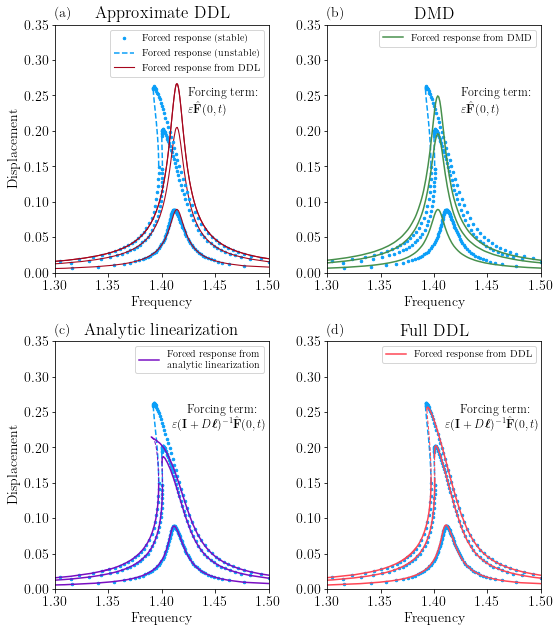

In [306]:
fig = plt.figure(figsize = (8,9))
ax = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)

ax.set_xlim(1.3, 1.5)

ax2.set_xlim(1.3, 1.5)
ax3.set_xlim(1.3, 1.5)
ax4.set_xlim(1.3, 1.5)

ax.set_ylim(0, 0.35)
ax2.set_ylim(0, 0.35)
ax3.set_ylim(0, 0.35)
ax4.set_ylim(0, 0.35)

for i in range(4):
    freq = 2*np.pi/np.squeeze(max_amps_nonl[i,0])

    amp = np.squeeze(max_amps_nonl[i,1])
    stab = np.squeeze(max_amps_nonl[i,2])

    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    freq_stab[stab==0] = np.nan
    amp_stab[stab==0] = np.nan
    if i < 3:
        freq_leading_ord = 2*np.pi/np.squeeze(max_amps_lin_leading_ord[i,0])
        amp_leading_ord = np.squeeze(max_amps_lin_leading_ord[i,1])
    
    
    if i == 0:
        ax.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], label = 'Forced response (stable)')
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],  label = 'Forced response (unstable)')
        ax2.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax3.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax4.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax4.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
    elif i < 3:
        ax.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0], )
        ax2.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax3.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax4.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax4.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
    
    
    
    
    freq = 2*np.pi/np.squeeze(max_amps_lin[i,0])
    amp = np.squeeze(max_amps_lin[i,1])
    stab = np.squeeze(max_amps_lin[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    if i < 3:
        freq_stab[stab==0] = np.nan
        amp_stab[stab==0] = np.nan
    if i == 0:
        ax4.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[1],label = 'Forced response from DDL')
        ax.plot(freq_leading_ord, amp_leading_ord, '-',linewidth = 1.1, c=colors2[3],label = 'Forced response from DDL')

    else:
        ax4.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[1],)
        ax.plot(freq_leading_ord, amp_leading_ord, '-',linewidth = 1.1, c=colors2[3])

    ax4.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1, c=colors2[1],)
    
    
    
    
    freq = 2*np.pi/np.squeeze(max_amps_lin_analytic[i,0])
    amp = np.squeeze(max_amps_lin_analytic[i,1])
    stab = np.squeeze(max_amps_lin_analytic[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    if i < 3:
        freq_stab[stab==0] = np.nan
        amp_stab[stab==0] = np.nan
    if i == 0:
        ax3.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[2],label = 'Forced response from \n analytic linearization')
    else:
#    elif i < 3:
        ax3.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[2],)
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1, c=colors2[2],)
ax3.set_xlim(1.3, 1.5)
ax2.plot(omegas, linear_resp[0,:], '-', linewidth = 1.5, c=colors2[4], label = 'Forced response from DMD')



#ax3.plot(omegas, max_amps_lin_leading_ord[0,:], '-', linewidth = 1, c=colors2[4], label = 'Forced response from DMD')

for i in range(1,3):
    ax2.plot(omegas, linear_resp[i,:], '-', linewidth = 1.5, c=colors2[4])



ax.legend(fontsize=10)
ax2.legend(fontsize =10)
ax3.legend(fontsize =10)
ax4.legend(fontsize =10)


ax.set_xlabel('Frequency')
ax2.set_xlabel('Frequency')
ax3.set_xlabel('Frequency')
ax4.set_xlabel('Frequency')

ax.set_ylabel('Displacement')
ax3.set_ylabel('Displacement')

labels = ['(a)', '(b)', '(c)', '(d)']
for a,l in zip([ax, ax2, ax3, ax4], labels):
    a.text(0, 1.03, l, transform=a.transAxes)

ax4.text(1.41, 0.26,r"Forcing term: \\$\varepsilon(\mathbf{I} + D\boldsymbol{\ell})^{-1}\hat{\mathbf{F}}(0,t)$", fontsize = 12, ha = 'left', va = 'top')
ax3.text(1.41, 0.26,r"Forcing term: \\$\varepsilon(\mathbf{I} + D\boldsymbol{\ell})^{-1}\hat{\mathbf{F}}(0,t)$", fontsize = 12, ha = 'left', va = 'top')

ax.text(1.425, 0.26,"Forcing term: \n $\\centering{\\varepsilon\\hat{\mathbf{F}}(0,t)}$", fontsize = 12, ha = 'left', va = 'top')
ax2.text(1.425, 0.26,"Forcing term: \n $\\centering{\\varepsilon\\hat{\mathbf{F}}(0,t)}$", fontsize = 12, ha = 'left', va = 'top')
ax.set_title('Approximate DDL')
ax2.set_title('DMD')
ax3.set_title('Analytic linearization')
ax4.set_title('Full DDL')




fig.tight_layout()
#plt.savefig('figure_12.pdf', bbox_inches='tight')

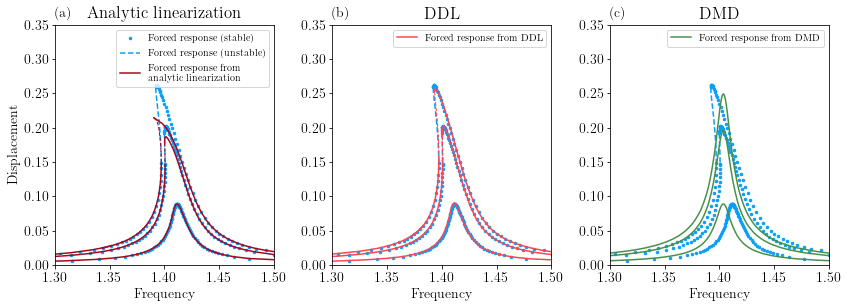

In [307]:
fig = plt.figure(figsize = (12,4.5))
ax = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

for i in range(4):
    freq = 2*np.pi/np.squeeze(max_amps_nonl[i,0])
    amp = np.squeeze(max_amps_nonl[i,1])
    stab = np.squeeze(max_amps_nonl[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    freq_stab[stab==0] = np.nan
    amp_stab[stab==0] = np.nan
    if i < 3:
        freq_leading_ord = 2*np.pi/np.squeeze(max_amps_lin_leading_ord[i,0])
        amp_leading_ord = np.squeeze(max_amps_lin_leading_ord[i,1])
    
    
    if i == 0:
        ax.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], label = 'Forced response (stable)')
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],  label = 'Forced response (unstable)')
        ax2.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax3.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0], )
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
    elif i < 3:
        ax.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0], )
        ax2.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
        ax3.plot(freq_stab, amp_stab, 'o',markersize = 2.5, c=colors2[0],)
        ax3.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1.5, c=colors2[0],)
    
    
    
    
    freq = 2*np.pi/np.squeeze(max_amps_lin[i,0])
    amp = np.squeeze(max_amps_lin[i,1])
    stab = np.squeeze(max_amps_lin[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    freq_stab[stab==0] = np.nan
    amp_stab[stab==0] = np.nan
    if i == 0:
        ax2.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[1],label = 'Forced response from DDL')
    else:
        ax2.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[1],)


    ax2.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1, c=colors2[1],)
    
    
    
    
    freq = 2*np.pi/np.squeeze(max_amps_lin_analytic[i,0])
    amp = np.squeeze(max_amps_lin_analytic[i,1])
    stab = np.squeeze(max_amps_lin_analytic[i,2])
    freq_stab = np.copy(freq)
    amp_stab = np.copy(amp)
    freq_stab[stab==0] = np.nan
    amp_stab[stab==0] = np.nan
    if i == 0:
        ax.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[3],label = 'Forced response from \n analytic linearization')
    else:
#    elif i < 3:
        ax.plot(freq_stab, amp_stab, '-',linewidth = 1.5, c=colors2[3],)
        ax.plot(freq[stab==0], amp[stab==0], '--',linewidth = 1, c=colors2[3],)
ax3.set_xlim(1.3, 1.5)
ax3.plot(omegas, linear_resp[0,:], '-', linewidth = 1.5, c=colors2[4], label = 'Forced response from DMD')



#ax3.plot(omegas, max_amps_lin_leading_ord[0,:], '-', linewidth = 1, c=colors2[4], label = 'Forced response from DMD')

for i in range(1,3):
    ax3.plot(omegas, linear_resp[i,:], '-', linewidth = 1.5, c=colors2[4])


ax.set_xlim(1.3, 1.5)

ax2.set_xlim(1.3, 1.5)
ax3.set_xlim(1.3, 1.5)

ax.set_ylim(0, 0.35)
ax2.set_ylim(0, 0.35)
ax3.set_ylim(0, 0.35)

ax.legend(fontsize=10)
ax2.legend(fontsize =10)
ax3.legend(fontsize =10)


ax.set_xlabel('Frequency')
ax2.set_xlabel('Frequency')
ax3.set_xlabel('Frequency')

ax.set_ylabel('Displacement')

labels = ['(a)', '(b)', '(c)']
for a,l in zip([ax, ax2, ax3], labels):
    a.text(0, 1.03, l, transform=a.transAxes)


ax3.set_title('DMD')
ax.set_title('Analytic linearization')
ax2.set_title('DDL')




fig.tight_layout()
#plt.savefig('figure6.pdf', bbox_inches='tight')